In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/README.md
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/ultimate.mat
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img4195.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img2945.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img3884.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img4643.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img4521.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img1748.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img2922.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_folder/img3398.png
/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset/Training/img_fold

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

In [3]:
import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.models import Model

def mlp(x, cf):
    x = L.Dense(cf["mlp_dim"], activation="gelu")(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    x = L.Dense(cf["hidden_dim"])(x)
    x = L.Dropout(cf["dropout_rate"])(x)
    return x

def transformer_encoder(x, cf):
    skip_1 = x
    x = L.LayerNormalization()(x)
    x = L.MultiHeadAttention(
        num_heads=cf["num_heads"], key_dim=cf["hidden_dim"]
    )(x, x)
    x = L.Add()([x, skip_1])

    skip_2 = x
    x = L.LayerNormalization()(x)
    x = mlp(x, cf)
    x = L.Add()([x, skip_2])

    return x

def conv_block(x, num_filters, kernel_size=3):
    x = L.Conv2D(num_filters, kernel_size=kernel_size, padding="    ")(x)
    x = L.BatchNormalization()(x)
    x = L.ReLU()(x)
    return x

def deconv_block(x, num_filters):
    x = L.Conv2DTranspose(num_filters, kernel_size=2, padding="same", strides=2)(x)
    return x

def build_unetr_2d(cf):
    """ Inputs """
    input_shape = (cf["image_size"], cf["image_size"], cf["num_channels"])
    inputs = L.Input(input_shape)

    # Resize the input image to the expected patch size
    x = L.Reshape((cf["num_patches"], cf["patch_size"] * cf["patch_size"] * cf["num_channels"]))(inputs)
    # x = L.Dense(cf["hidden_dim"])(x)
    
    # """ Inputs """
    # input_shape = (cf["num_patches"], cf["patch_size"]*cf["patch_size"]*cf["num_channels"])
    # inputs = L.Input(input_shape) ## (None, 256, 768)

    # """ Patch + Position Embeddings """
    patch_embed = L.Dense(cf["hidden_dim"])(x) ## (None, 256, 768)

    positions = tf.range(start=0, limit=cf["num_patches"], delta=1) ## (256,)
    pos_embed = L.Embedding(input_dim=cf["num_patches"], output_dim=cf["hidden_dim"])(positions) ## (256, 768)
    x = patch_embed + pos_embed ## (None, 256, 768)

    """ Transformer Encoder """
    skip_connection_index = [3, 6, 9, 12]
    skip_connections = []

    for i in range(1, cf["num_layers"]+1, 1):
        x = transformer_encoder(x, cf)

        if i in skip_connection_index:
            skip_connections.append(x)

    """ CNN Decoder """
    z3, z6, z9, z12 = skip_connections

    ## Reshaping
    z0 = L.Reshape((cf["image_size"], cf["image_size"], cf["num_channels"]))(inputs)
    z3 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z3)
    z6 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z6)
    z9 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z9)
    z12 = L.Reshape((cf["patch_size"], cf["patch_size"], cf["hidden_dim"]))(z12)

    ## Decoder 1
    x = deconv_block(z12, 512)

    s = deconv_block(z9, 512)
    s = conv_block(s, 512)
    x = L.Concatenate()([x, s])

    x = conv_block(x, 512)
    x = conv_block(x, 512)

    ## Decoder 2
    x = deconv_block(x, 256)

    s = deconv_block(z6, 256)
    s = conv_block(s, 256)
    s = deconv_block(s, 256)
    s = conv_block(s, 256)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 256)
    x = conv_block(x, 256)

    ## Decoder 3
    x = deconv_block(x, 128)

    s = deconv_block(z3, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)
    s = deconv_block(s, 128)
    s = conv_block(s, 128)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 128)
    x = conv_block(x, 128)

    ## Decoder 4
    x = deconv_block(x, 64)

    s = conv_block(z0, 64)
    s = conv_block(s, 64)

    x = L.Concatenate()([x, s])
    x = conv_block(x, 64)
    x = conv_block(x, 64)

    """ Output """
    # outputs = L.Conv2D(11, kernel_size=1, padding="same", activation="sigmoid")(x)
    outputs = L.Conv2D(11, kernel_size=1, padding="same", activation="softmax")(x)


    return Model(inputs, outputs, name="UNETR_2D")

if __name__ == "__main__":
    config = {}
    config["image_size"] = 256
    config["num_layers"] = 12
    config["hidden_dim"] = 768
    config["mlp_dim"] = 3072
    config["num_heads"] = 12
    config["dropout_rate"] = 0.1
    config["num_patches"] = 256
    config["patch_size"] = 16
    config["num_channels"] = 3

    model = build_unetr_2d(config)
    model.summary()

Model: "UNETR_2D"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 reshape (Reshape)           (None, 256, 768)             0         ['input_1[0][0]']             
                                                                                                  
 dense (Dense)               (None, 256, 768)             590592    ['reshape[0][0]']             
                                                                                                  
 tf.math.add (TFOpLambda)    (None, 256, 768)             0         ['dense[0][0]']               
                                                                                           

In [4]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import numpy as np
import pandas as pd
import cv2
from glob import glob
import scipy.io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping

""" Global parameters """
global IMG_H
global IMG_W
global NUM_CLASSES
global CLASSES
global COLORMAP

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Load and split the dataset """
 

    split_size = int(split * len(images))

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def get_colormap(path):
    mat_path = os.path.join(path, "ultimate.mat")
    colormap = scipy.io.loadmat(mat_path)["color"]

    classes = [
        "Background",
        "Spleen",
        "Right kidney",
        "Left kidney",
        "Liver",
        "Gallbladder",
        "Stomach",
        "Aorta",
        "Inferior vena cava",
        "Portal vein",
        "Pancreas"
    ]

    return classes, colormap

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_W, IMG_H))

    output = []

    for color in COLORMAP:
        cmap = np.all(np.equal(x, color), axis=-1)
        output.append(cmap)

    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return output
def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x = read_image(x)
        y = read_mask(y)

        return x, y


    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_H, IMG_W, 3])
    mask.set_shape([IMG_H, IMG_W, NUM_CLASSES])

    return image, mask

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("/kaggle/working/files")

    """ Hyperparameters """
    IMG_H = 256
    IMG_W = 256
    NUM_CLASSES = 11

    batch_size = 16  # Adjust this based on TPU memory constraints
    lr = 1e-4
    num_epochs = 40

    config = {
        "image_size": 256,
        "num_layers": 12,
        "hidden_dim": 768,
        "mlp_dim": 3072,
        "num_heads": 12,
        "dropout_rate": 0.1,
        "num_patches": 256,
        "patch_size": 16,
        "num_channels": 3
    }

    dataset_path = "/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset"
    model_path = os.path.join("/kaggle/working/files", "Ultimate_unter_model.h5")
    csv_path = os.path.join("/kaggle/working/files", "Unetr_Ultimate_data.csv")

    """ Loading the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_x)}")

    """ Process the colormap """
    CLASSES, COLORMAP = get_colormap(dataset_path)

    """ Dataset Pipeline """
    train_dataset = tf_dataset(train_x, train_y, batch=batch_size)
    valid_dataset = tf_dataset(valid_x, valid_y, batch=batch_size)

    """ TPU Configuration """
    resolver = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(resolver)
    tf.tpu.experimental.initialize_tpu_system(resolver)

    strategy = tf.distribute.experimental.TPUStrategy(resolver)

    with strategy.scope():
        """ Model """
        
        model = build_unetr_2d(config)
        model.compile(
            loss="categorical_crossentropy",
            optimizer=tf.keras.optimizers.Adam(lr)
        )

        """ Training """
        callbacks = [
            ModelCheckpoint(model_path, verbose=1, save_best_only=True),
            ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1),
            CSVLogger(csv_path, append=True),
            EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=False)
        ]

        model.fit(train_dataset,
                  validation_data=valid_dataset,
                  epochs=num_epochs,
                  callbacks=callbacks
                  )

Train: 2832/2832 - Valid: 944/944 - Test: 944/944
INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Deallocate tpu buffers before initializing tpu system.


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Initializing the TPU system: local


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)
2023-12-10 02:13:40.414028: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:13:40.414150: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:13:55.969352: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:13:55.988003: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:13:56.006053: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:13:56.023923: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this

Epoch 1/40


2023-12-10 02:14:29.610973: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.
2023-12-10 02:14:33.764769: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:14:33.768077: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:14:33.768253: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:14:33.769041: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:14:33.769251: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:14:33.770027: E ./tensorflow/compiler/xla/stream_executor/st

  1/177 [..............................] - ETA: 5:59:45 - loss: 2.3898

2023-12-10 02:15:59.147767: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


  9/177 [>.............................] - ETA: 36s - loss: 2.2044

2023-12-10 02:16:01.134808: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 12/177 [=>............................] - ETA: 51s - loss: 2.1592

2023-12-10 02:16:02.402470: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.
2023-12-10 02:16:03.011281: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 13/177 [=>............................] - ETA: 55s - loss: 2.1472

2023-12-10 02:16:03.607554: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 17/177 [=>............................] - ETA: 1:04 - loss: 2.0916

2023-12-10 02:16:05.399898: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 21/177 [==>...........................] - ETA: 1:10 - loss: 2.0450

2023-12-10 02:16:08.001093: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


 22/177 [==>...........................] - ETA: 1:11 - loss: 2.0346

2023-12-10 02:16:08.598557: E ./tensorflow/compiler/xla/stream_executor/stream_executor_internal.h:124] SetPriority unimplemented for this stream.


177/177 [==============================] - ETA: 0s - loss: 1.2298

2023-12-10 02:17:48.177497: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node AssignAddVariableOp.



Epoch 1: val_loss improved from inf to 1.39954, saving model to /kaggle/working/files/Ultimate_unter_model.h5


/usr/local/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


177/177 [==============================] - 292s 960ms/step - loss: 1.2298 - val_loss: 1.3995 - lr: 1.0000e-04
Epoch 2/40
177/177 [==============================] - ETA: 0s - loss: 0.6207
Epoch 2: val_loss improved from 1.39954 to 0.59771, saving model to /kaggle/working/files/Ultimate_unter_model.h5
177/177 [==============================] - 142s 802ms/step - loss: 0.6207 - val_loss: 0.5977 - lr: 1.0000e-04
Epoch 3/40
177/177 [==============================] - ETA: 0s - loss: 0.4224
Epoch 3: val_loss improved from 0.59771 to 0.44411, saving model to /kaggle/working/files/Ultimate_unter_model.h5
177/177 [==============================] - 142s 806ms/step - loss: 0.4224 - val_loss: 0.4441 - lr: 1.0000e-04
Epoch 4/40
177/177 [==============================] - ETA: 0s - loss: 0.3193
Epoch 4: val_loss improved from 0.44411 to 0.33636, saving model to /kaggle/working/files/Ultimate_unter_model.h5
177/177 [==============================] - 141s 799ms/step - loss: 0.3193 - val_loss: 0.3364 - lr

In [7]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
 
import tensorflow as tf
from sklearn.metrics import accuracy_score, f1_score, jaccard_score, precision_score, recall_score
import scipy.io
from sklearn.model_selection import train_test_split
import tensorflow as tf
from PIL import Image
# from train import load_dataset, create_dir, get_colormap

""" Global parameters """
global IMG_H
global IMG_W
global NUM_CLASSES
global CLASSES
global COLORMAP

""" Creating a directory """
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

""" Load and split the dataset """
def load_dataset(path, split=0.2):
    images = sorted(glob(os.path.join(path, "Training", "img_folder", "*")))[:4720]
    masks = sorted(glob(os.path.join(path, "Training", "mask_folder", "*")))[:4720]

    split_size = int(split * len(images))

    train_x, valid_x = train_test_split(images, test_size=split_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=split_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=split_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=split_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)


def get_colormap(path):
    mat_path = os.path.join(path, "ultimate.mat")
    colormap = scipy.io.loadmat(mat_path)["color"]

    classes = [
        "Background",
        "Spleen",
        "Right kidney",
        "Left kidney",
        "Gallbladder",
        "Liver",
        "Stomach",
        "Aorta",
        "Inferior vena cava",
        "Portal vein",
        "Pancreas"
    ]

    return classes, colormap

def read_image(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_W, IMG_H))
    x = x.astype(np.float32)
    return x

def read_mask(x):
    x = cv2.imread(x, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMG_W, IMG_H))

    #Masl processing
    output=[]
    # for i,color in enumerate(COLORMAP):
    #   cmap = np.all(np.equal(x, color), axis=-1)
    #   cv2.imwrite(f"cmap{i}.png", cmap*255)
    for color in COLORMAP:
      cmap = np.all(np.equal(x, color), axis=-1)
      output.append(cmap)


    output = np.stack(output, axis=-1)
    output = output.astype(np.uint8)

    return output


def preprocess(x, y):
    def f(x, y):
        x = x.decode()
        y = y.decode()

        x =read_image(x)
        y=read_mask(y)

        return x,y

    image, mask = tf.numpy_function(f, [x, y], [tf.float32, tf.uint8])
    image.set_shape([IMG_H, IMG_W, 3])
    mask.set_shape([IMG_H, IMG_W, NUM_CLASSES])

    return image, mask

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.shuffle(buffer_size=5000)
    dataset = dataset.map(preprocess)
    dataset = dataset.batch(batch)
    dataset = dataset.prefetch(2)
    return dataset


def grayscale_to_rgb(mask, classes, colormap):
    h, w, _ = mask.shape
    mask = mask.astype(np.int32)
    output = []

    for i, pixel in enumerate(mask.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h, w, 3))
    return output

def save_results(image, mask, pred, save_image_path):
    # print(image.shape,mask.shape,pred.shape)
    h, w, _ = image.shape
    line = np.ones((h, 10, 3)) * 255

    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred, CLASSES, COLORMAP)

    # Ensure both images have the same shape
    assert image.shape == mask.shape
    assert image.shape == pred.shape

    # Blend the images using the alpha parameter
    alpha = 0.5
    blended_image1 = alpha * image + (1 - alpha) * mask
    blended_image2 = alpha * image + (1 - alpha) * pred
    # alpha = 0.5
    # blended_image1 = Image.blend(image, mask, alpha)
    # blended_image2 = Image.blend(image, pred, alpha)

    cat_images = np.concatenate([image, line, mask, line, pred, line, blended_image1, blended_image2], axis=1)
    cv2.imwrite(save_image_path, cat_images)


if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42)
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("files")

    """ Directory for storing files """
    create_dir("results2/predictions")

    """ Hyperparameters """
    IMG_H = 256
    IMG_W = 256
    NUM_CLASSES = 11
    dataset_path = "/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset"
    # dataset_path = "/content/drive/MyDrive/human"
    # model_path = os.path.join("files", "model1.h5")
    model_path = "/kaggle/working/files/Ultimate_unter_model.h5"

    """ Colormap """
    CLASSES, COLORMAP = get_colormap(dataset_path)

    """ Model """
    model = tf.keras.models.load_model(model_path)
    # model.summary()

    """ Load the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_y)}")
    print("")

    # Prediction and Evaluation

    SCORE = []
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
      name = x.split("/")[-1].split(".")[0]

      """ Reading the image """
      image = cv2.imread(x, cv2.IMREAD_COLOR)
      image = cv2.resize(image, (IMG_W, IMG_H))
      image_x = image
      # image = image/255.0
      image = np.expand_dims(image, axis=0)

      """ Reading the mask """
      mask = cv2.imread(y, cv2.IMREAD_COLOR)
      mask = cv2.resize(mask, (IMG_W, IMG_H))
      mask_x = mask
      onehot_mask = []
      for color in COLORMAP:
          cmap = np.all(np.equal(mask, color), axis=-1)
          onehot_mask.append(cmap)
      onehot_mask = np.stack(onehot_mask, axis=-1)
      onehot_mask = np.argmax(onehot_mask, axis=-1)
      onehot_mask = onehot_mask.astype(np.int32)

      """ Prediction """
      pred = model.predict(image, verbose=0)[0]
      pred = np.argmax(pred, axis=-1)
      pred = pred.astype(np.float32)

      """ Saving the prediction """
      save_image_path = f"results2/predictions/{name}.png"
      save_results(image_x, mask_x, pred, save_image_path)

      """ Flatten the array """
      onehot_mask = onehot_mask.flatten()
      pred = pred.flatten()

      labels = [i for i in range(NUM_CLASSES)]

      """ Calculating the metrics values """
      f1_value = f1_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
      jac_value = jaccard_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
    
      SCORE.append([f1_value, jac_value])

    """ Metrics values """
    score = np.array(SCORE)
    score = np.mean(score, axis=0)

    # Calculate accuracy using true labels and predicted labels
    accuracy = accuracy_score(onehot_mask, pred.flatten())

    f = open("files/score.csv", "w")
    f.write("Class,F1,Jaccard,Accuracy\n")

    l = ["Class", "F1", "Jaccard", "Accuracy"]
    print(f"{l[0]:15s} {l[1]:10s} {l[2]:10s} {l[3]:10s}")
    print("-" * 50)

    for i in range(score.shape[1]):
        class_name = CLASSES[i]
        f1 = score[0, i]
        jac = score[1, i]
        dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f} - {accuracy:1.5f}"
        print(dstr)
        f.write(f"{class_name:15s},{f1:1.5f},{jac:1.5f},{accuracy:1.5f}\n")
     
    print("-" * 50)
    class_mean = np.mean(score, axis=-1)
    class_name = "Mean"
    f1 = class_mean[0]
    jac = class_mean[1]
    dstr = f"{class_name:15s}: {f1:1.5f} - {jac:1.5f} - {accuracy:1.5f}"
    print(dstr)
    f.write(f"{class_name:15s},{f1:1.5f},{jac:1.5f},{accuracy:1.5f}\n")

    f.close()

Train: 2832/2832 - Valid: 944/944 - Test: 944/944



100%|██████████| 944/944 [12:46<00:00,  1.23it/s]

Class           F1         Jaccard    Accuracy  
--------------------------------------------------
Background     : 0.99033 - 0.98096 - 0.96687
Spleen         : 0.33131 - 0.28814 - 0.96687
Right kidney   : 0.38122 - 0.32973 - 0.96687
Left kidney    : 0.36173 - 0.30669 - 0.96687
Gallbladder    : 0.68703 - 0.63348 - 0.96687
Liver          : 0.00000 - 0.00000 - 0.96687
Stomach        : 0.36724 - 0.29869 - 0.96687
Aorta          : 0.59835 - 0.50674 - 0.96687
Inferior vena cava: 0.57809 - 0.47715 - 0.96687
Portal vein    : 0.04552 - 0.02843 - 0.96687
Pancreas       : 0.18855 - 0.13735 - 0.96687
--------------------------------------------------
Mean           : 0.41176 - 0.36249 - 0.96687


Train: 2832/2832 - Valid: 944/944 - Test: 944/944



  0%|          | 0/944 [00:00<?, ?it/s]

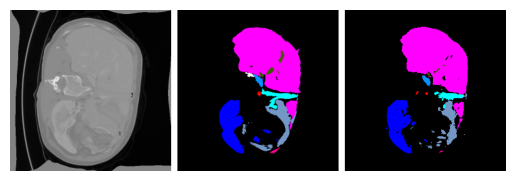

  0%|          | 1/944 [00:03<57:19,  3.65s/it]

F1 Score: [0.98106018 0.48780488 0.         0.91059212 0.95343169 0.
 0.63520871 0.58064516 0.90763052 0.3286385  0.68045977 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96282447 0.32258065 0.         0.83585968 0.9110076  0.
 0.46542553 0.40909091 0.83088235 0.19662921 0.51567944 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


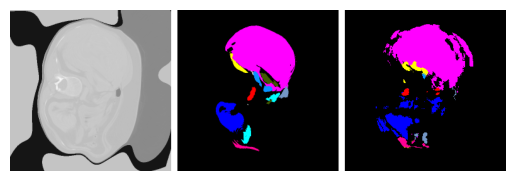

  0%|          | 2/944 [00:04<31:23,  2.00s/it]

F1 Score: [0.96007739 0.37940379 0.33020638 0.52101401 0.84549965 0.
 0.09771987 0.         0.25954198 0.00966184 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.92322004 0.23411371 0.19775281 0.35227785 0.73235114 0.
 0.05136986 0.         0.14912281 0.00485437 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


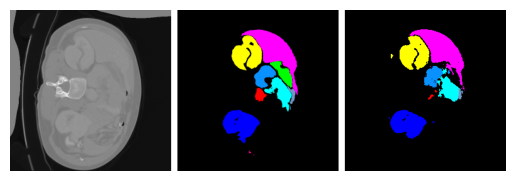

  0%|          | 3/944 [00:05<23:03,  1.47s/it]

F1 Score: [0.98209986 0.         0.9447889  0.95833333 0.94468085 0.
 0.58585859 0.24       0.80412371 0.         0.69420539 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96482929 0.         0.89535534 0.92       0.89516129 0.
 0.41428571 0.13636364 0.67241379 0.         0.53163445 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


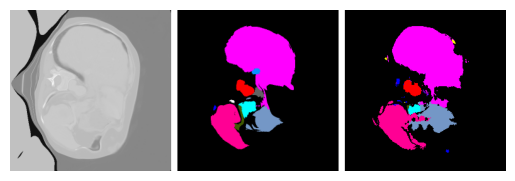

  0%|          | 4/944 [00:06<19:09,  1.22s/it]

F1 Score: [0.97357973 0.848659   0.         0.         0.9334432  0.
 0.62446139 0.91422367 0.02197802 0.13684211 0.61949686 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.94851959 0.73710483 0.         0.         0.87519315 0.
 0.4539759  0.842      0.01111111 0.07344633 0.44874715 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


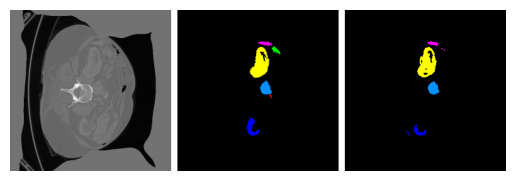

  1%|          | 5/944 [00:07<17:35,  1.12s/it]

F1 Score: [0.99648203 0.         0.89275362 0.60957179 0.78313253 0.
 0.         0.         0.95568401 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99298873 0.         0.80628272 0.4384058  0.64356436 0.
 0.         0.         0.91512915 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


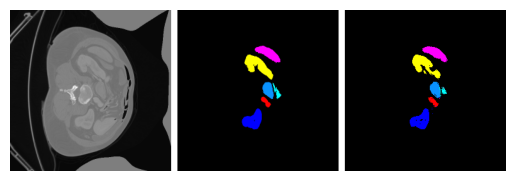

  1%|          | 6/944 [00:08<16:38,  1.06s/it]

F1 Score: [0.99696929 0.         0.9037037  0.94947875 0.95445135 0.
 0.         0.88983051 0.92079208 0.         0.46153846 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99395689 0.         0.82432432 0.90381679 0.91287129 0.
 0.         0.80152672 0.85321101 0.         0.3        0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


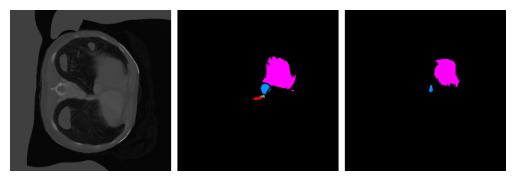

  1%|          | 7/944 [00:08<15:27,  1.01it/s]

F1 Score: [0.99555125 0.         0.         0.         0.85267098 0.
 0.         0.         0.5106383  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9911419  0.         0.         0.         0.74317912 0.
 0.         0.         0.34285714 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


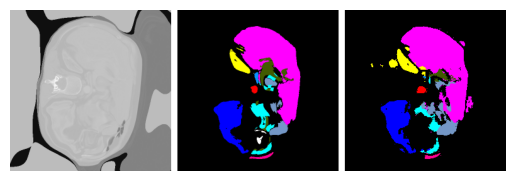

  1%|          | 8/944 [00:09<14:41,  1.06it/s]

F1 Score: [0.97257545 0.70852018 0.70527097 0.90994152 0.90087464 0.
 0.55794442 0.77391304 0.27160494 0.29945554 0.50952986 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.94661497 0.54861111 0.54472477 0.83476395 0.81962865 0.
 0.38690909 0.63120567 0.15714286 0.17609392 0.34185848 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


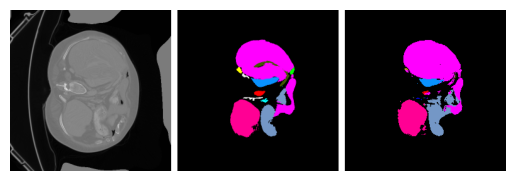

  1%|          | 9/944 [00:10<14:15,  1.09it/s]

F1 Score: [0.99068931 0.96285064 0.31372549 0.         0.92403662 0.
 0.75522851 0.46031746 0.86079545 0.13793103 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9815504  0.92836257 0.18604651 0.         0.85879933 0.
 0.6067206  0.29896907 0.75561097 0.07407407 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


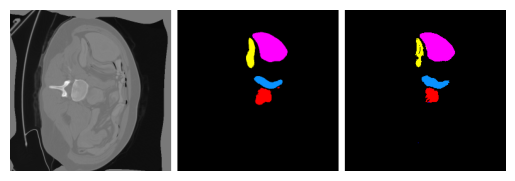

  1%|          | 10/944 [00:11<14:28,  1.08it/s]

F1 Score: [0.99681788 0.         0.82012579 0.         0.98607407 0.
 0.         0.86175115 0.90585774 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99365596 0.         0.69509595 0.         0.97253068 0.
 0.         0.75708502 0.82791587 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


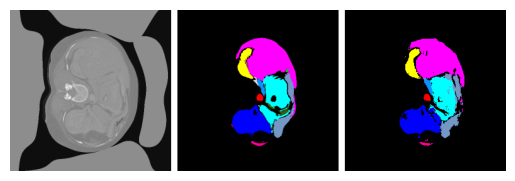

  1%|          | 11/944 [00:12<14:00,  1.11it/s]

F1 Score: [0.98502863 0.77464789 0.92687075 0.8924199  0.93305613 0.
 0.74884438 0.91489362 0.82508251 0.01980198 0.78182288 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97049894 0.63218391 0.8637084  0.80573848 0.87451286 0.
 0.59852217 0.84313725 0.70224719 0.01       0.64179737 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


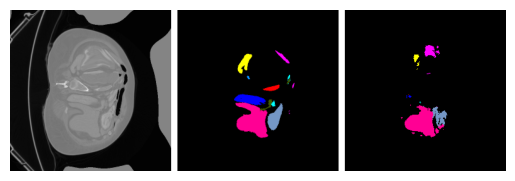

  1%|▏         | 12/944 [00:13<13:41,  1.13it/s]

F1 Score: [0.98401934 0.87698898 0.3562341  0.06754221 0.         0.
 0.59664804 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96854141 0.78092643 0.21671827 0.03495146 0.         0.
 0.42515924 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


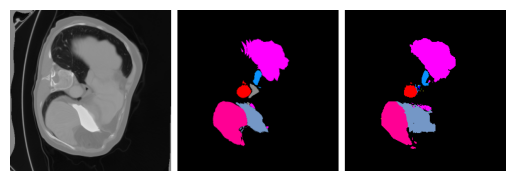

  1%|▏         | 13/944 [00:14<13:40,  1.13it/s]

F1 Score: [0.99110209 0.89554168 0.         0.         0.92416582 0.
 0.7162932  0.89850746 0.80397022 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98236113 0.81084243 0.         0.         0.85902256 0.
 0.55798817 0.81571816 0.67219917 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


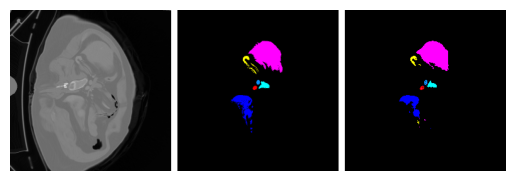

  1%|▏         | 14/944 [00:15<13:38,  1.14it/s]

F1 Score: [0.99627137 0.         0.69512195 0.78615071 0.94398409 0.
 0.         0.84745763 0.87719298 0.         0.82926829 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99257044 0.         0.53271028 0.64765101 0.89391086 0.
 0.         0.73529412 0.78125    0.         0.70833333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


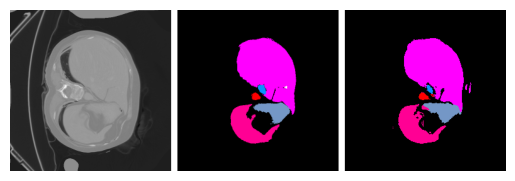

  2%|▏         | 15/944 [00:15<13:33,  1.14it/s]

F1 Score: [0.99302083 0.93989071 0.         0.         0.97092815 0.
 0.88686481 0.81060606 0.81308411 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9861384  0.88659794 0.         0.         0.94349888 0.
 0.79672696 0.68152866 0.68503937 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


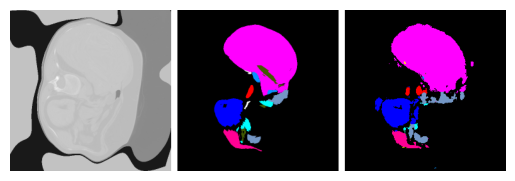

  2%|▏         | 16/944 [00:16<13:52,  1.11it/s]

F1 Score: [0.97665043 0.88272158 0.         0.8129813  0.93335781 0.
 0.5026455  0.46666667 0.13483146 0.02285714 0.26829268 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95436638 0.7900641  0.         0.68489342 0.87504303 0.
 0.33568905 0.30434783 0.07228916 0.01156069 0.15492958 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


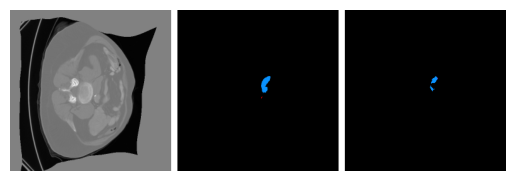

  2%|▏         | 17/944 [00:17<13:33,  1.14it/s]

F1 Score: [0.99918185 0.         0.         0.         0.         0.
 0.         0.         0.63414634 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99836504 0.         0.         0.         0.         0.
 0.         0.         0.46428571 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


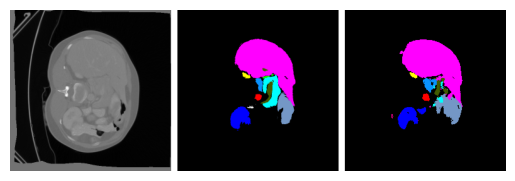

  2%|▏         | 18/944 [00:18<13:29,  1.14it/s]

F1 Score: [0.9889274  0.         0.83464567 0.88535032 0.95306143 0.
 0.71247357 0.81081081 0.60229885 0.50963597 0.25611176 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97809731 0.         0.71621622 0.79428571 0.91033175 0.
 0.55336617 0.68181818 0.43092105 0.34195402 0.14686248 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


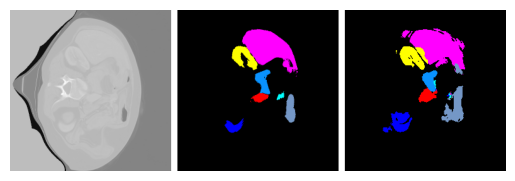

  2%|▏         | 19/944 [00:19<13:18,  1.16it/s]

F1 Score: [0.97854368 0.         0.7699115  0.52905464 0.84045414 0.
 0.57430432 0.70121951 0.84824903 0.         0.28571429 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95798877 0.         0.62589928 0.35966981 0.72481319 0.
 0.40282392 0.5399061  0.73648649 0.         0.16666667 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


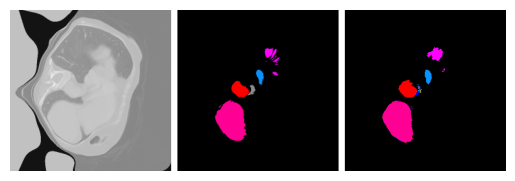

  2%|▏         | 20/944 [00:20<13:13,  1.16it/s]

F1 Score: [0.99444739 0.95691203 0.         0.         0.52413793 0.
 0.         0.8935743  0.82253521 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9889561  0.91738382 0.         0.         0.35514019 0.
 0.         0.8076225  0.69856459 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


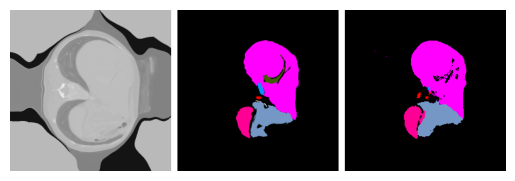

  2%|▏         | 21/944 [00:21<13:25,  1.15it/s]

F1 Score: [0.98919692 0.88105263 0.         0.         0.93278228 0.
 0.85273217 0.3125     0.24193548 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97862477 0.78739417 0.         0.         0.87403186 0.
 0.74327211 0.18518519 0.13761468 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


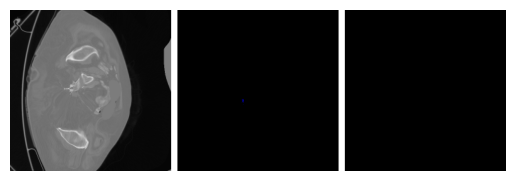

  2%|▏         | 22/944 [00:22<13:51,  1.11it/s]

F1 Score: [0.99997711 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99995422 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


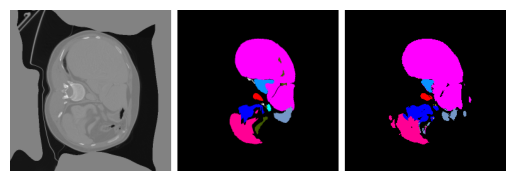

  2%|▏         | 23/944 [00:22<13:47,  1.11it/s]

F1 Score: [0.98851276 0.84478936 0.         0.62116992 0.96222782 0.
 0.62565445 0.8125     0.7827476  0.12962963 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97728643 0.73128599 0.         0.45050505 0.92720525 0.
 0.4552381  0.68421053 0.64304462 0.06930693 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


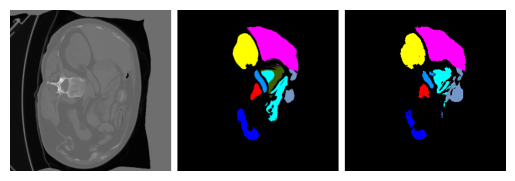

  3%|▎         | 24/944 [00:23<13:39,  1.12it/s]

F1 Score: [0.98691019 0.         0.97604599 0.86509275 0.96635547 0.
 0.59366516 0.83137255 0.7959596  0.         0.36292135 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97415863 0.         0.95321273 0.76225854 0.93490116 0.
 0.42213642 0.7114094  0.66107383 0.         0.2216884  0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


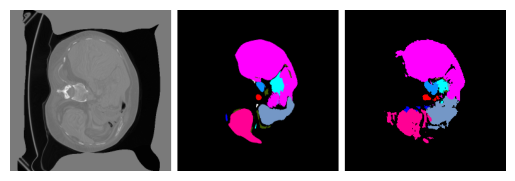

  3%|▎         | 25/944 [00:24<13:23,  1.14it/s]

F1 Score: [0.98304452 0.80736196 0.         0.         0.91245262 0.
 0.67754806 0.59487179 0.57522124 0.01010101 0.64480874 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96665443 0.67695473 0.         0.         0.83900034 0.
 0.51234229 0.42335766 0.40372671 0.00507614 0.47580645 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


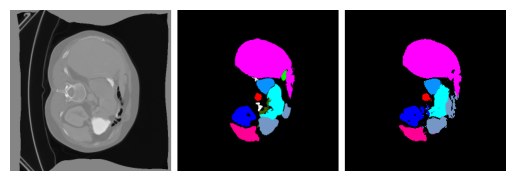

  3%|▎         | 26/944 [00:25<14:01,  1.09it/s]

F1 Score: [0.99036588 0.92862093 0.         0.86650775 0.97100339 0.
 0.72318158 0.85454545 0.92291447 0.         0.76323388 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98091563 0.86675291 0.         0.76445846 0.943641   0.
 0.56639344 0.74603175 0.85686275 0.         0.61712062 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


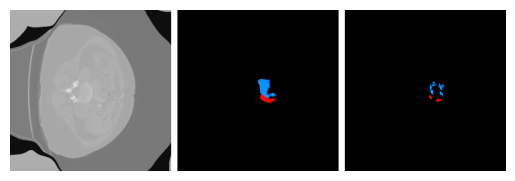

  3%|▎         | 27/944 [00:26<13:42,  1.12it/s]

F1 Score: [0.99651686 0.         0.         0.         0.         0.
 0.         0.52910053 0.32162662 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99305789 0.         0.         0.         0.         0.
 0.         0.35971223 0.19162996 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


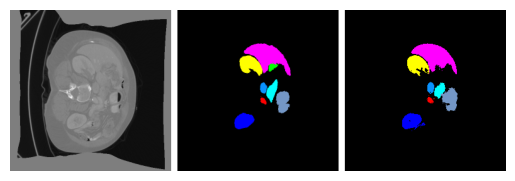

  3%|▎         | 28/944 [00:27<13:33,  1.13it/s]

F1 Score: [0.99404272 0.         0.91225627 0.93853821 0.9455081  0.
 0.80912162 0.82608696 0.89726027 0.         0.8534202  0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.988156   0.         0.83866837 0.88419405 0.89664804 0.
 0.67943262 0.7037037  0.8136646  0.         0.74431818 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


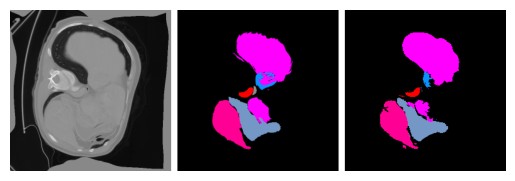

  3%|▎         | 29/944 [00:28<13:25,  1.14it/s]

F1 Score: [0.98724718 0.96545731 0.         0.         0.89276715 0.
 0.91699801 0.90909091 0.58076923 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97481553 0.93322134 0.         0.         0.80630479 0.
 0.84671868 0.83333333 0.40921409 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


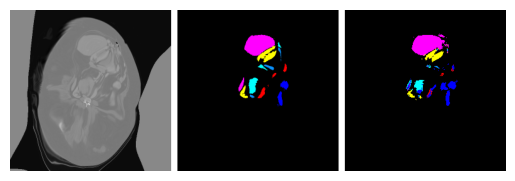

  3%|▎         | 30/944 [00:29<13:20,  1.14it/s]

F1 Score: [0.9945286  0.         0.80867347 0.53088042 0.89954148 0.
 0.         0.52631579 0.3875969  0.         0.60077519 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98911674 0.         0.67880086 0.36135957 0.81742424 0.
 0.         0.35714286 0.24038462 0.         0.42936288 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


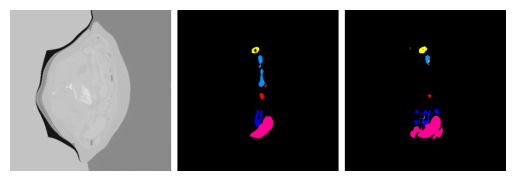

  3%|▎         | 31/944 [00:29<13:15,  1.15it/s]

F1 Score: [0.99378138 0.7581139  0.71111111 0.53427896 0.         0.
 0.         0.61971831 0.40433213 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98763962 0.61045365 0.55172414 0.36451613 0.         0.
 0.         0.44897959 0.25339367 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


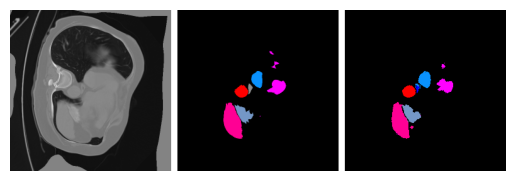

  3%|▎         | 32/944 [00:30<13:07,  1.16it/s]

F1 Score: [0.9959576  0.95554558 0.         0.         0.79507279 0.
 0.90182648 0.95222405 0.8935611  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99194776 0.91487532 0.         0.         0.6598513  0.
 0.82120582 0.90880503 0.80760095 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


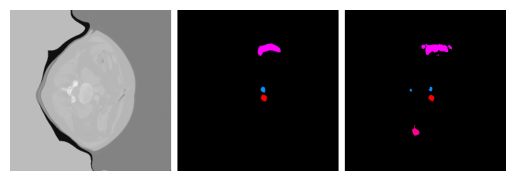

  3%|▎         | 33/944 [00:31<12:59,  1.17it/s]

F1 Score: [0.99778329 0.         0.         0.         0.81508516 0.
 0.         0.96350365 0.65116279 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99557638 0.         0.         0.         0.68788501 0.
 0.         0.92957746 0.48275862 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


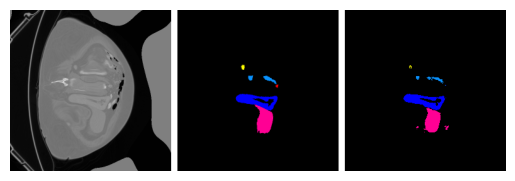

  4%|▎         | 34/944 [00:32<12:52,  1.18it/s]

F1 Score: [0.99753083 0.91471889 0.66666667 0.93431553 0.         0.
 0.         0.         0.66942149 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99507381 0.84284051 0.5        0.87672811 0.         0.
 0.         0.         0.50310559 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


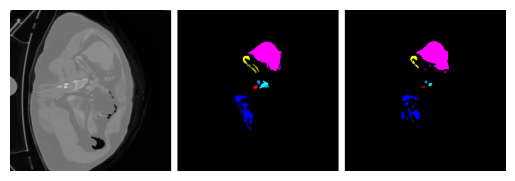

  4%|▎         | 35/944 [00:33<12:53,  1.17it/s]

F1 Score: [0.99538779 0.         0.68263473 0.54084507 0.9513435  0.
 0.         0.63414634 0.88235294 0.         0.35789474 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99081794 0.         0.51818182 0.37065637 0.90720222 0.
 0.         0.46428571 0.78947368 0.         0.21794872 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


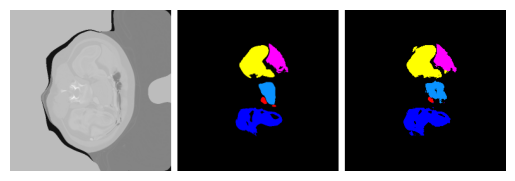

  4%|▍         | 36/944 [00:34<12:49,  1.18it/s]

F1 Score: [0.9914721  0.         0.93288963 0.90189613 0.91234805 0.
 0.         0.70769231 0.79468242 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98308842 0.         0.87422037 0.82132132 0.83882353 0.
 0.         0.54761905 0.65931373 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


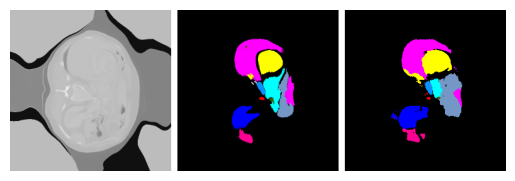

  4%|▍         | 37/944 [00:35<13:29,  1.12it/s]

F1 Score: [0.98539957 0.72230653 0.82323049 0.82592593 0.88875855 0.
 0.62205029 0.66666667 0.86928105 0.25454545 0.54101996 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97121935 0.56532067 0.69956817 0.70347003 0.79978888 0.
 0.45143178 0.5        0.76878613 0.14583333 0.37082067 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


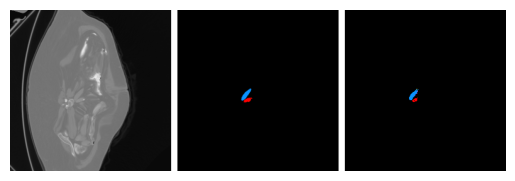

  4%|▍         | 38/944 [00:36<13:50,  1.09it/s]

F1 Score: [0.99974002 0.         0.         0.         0.         0.
 0.         0.79012346 0.92753623 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99948018 0.         0.         0.         0.         0.
 0.         0.65306122 0.86486486 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


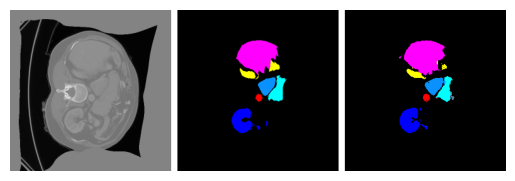

  4%|▍         | 39/944 [00:37<14:35,  1.03it/s]

F1 Score: [0.99362007 0.         0.73746313 0.92405063 0.94632124 0.
 0.         0.88659794 0.92706334 0.         0.88029466 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98732104 0.         0.58411215 0.85882353 0.89811172 0.
 0.         0.7962963  0.86404293 0.         0.78618421 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


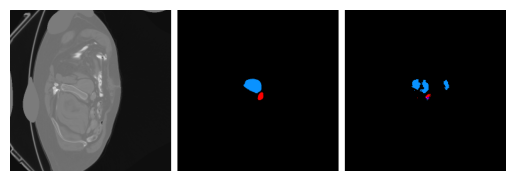

  4%|▍         | 40/944 [00:38<14:26,  1.04it/s]

F1 Score: [0.9980784  0.         0.         0.         0.         0.
 0.         0.57943925 0.74238876 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99616417 0.         0.         0.         0.         0.
 0.         0.40789474 0.59031657 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


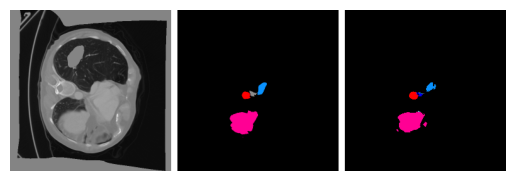

  4%|▍         | 41/944 [00:39<13:54,  1.08it/s]

F1 Score: [0.99725622 0.91008672 0.         0.         0.         0.
 0.         0.89156627 0.71186441 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99452745 0.83500838 0.         0.         0.         0.
 0.         0.80434783 0.55263158 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


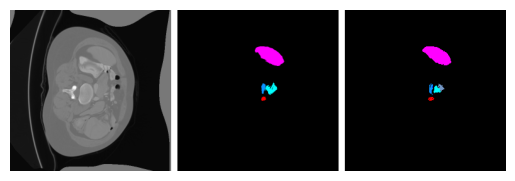

  4%|▍         | 42/944 [00:39<13:34,  1.11it/s]

F1 Score: [0.99870471 0.         0.         0.         0.97062424 0.
 0.         0.75362319 0.83969466 0.         0.55284553 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99741278 0.         0.         0.         0.94292509 0.
 0.         0.60465116 0.72368421 0.         0.38202247 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


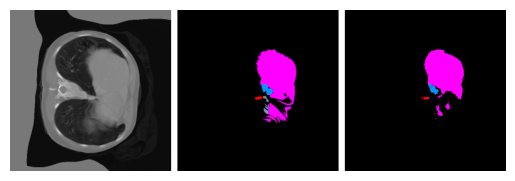

  5%|▍         | 43/944 [00:40<13:15,  1.13it/s]

F1 Score: [0.99204956 0.         0.         0.         0.88622912 0.
 0.         0.83544304 0.7961165  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98422453 0.         0.         0.         0.79570146 0.
 0.         0.7173913  0.66129032 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


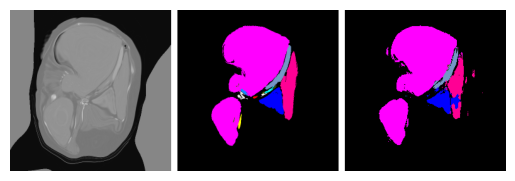

  5%|▍         | 44/944 [00:41<13:03,  1.15it/s]

F1 Score: [0.9892879  0.81981676 0.         0.81837838 0.96818556 0.
 0.84372177 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97880287 0.6946521  0.         0.6925892  0.93833302 0.
 0.7296875  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


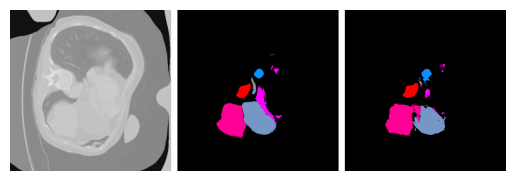

  5%|▍         | 45/944 [00:42<12:58,  1.16it/s]

F1 Score: [0.99078322 0.88810237 0.         0.         0.30014859 0.
 0.76218787 0.8969521  0.80851064 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98173479 0.79872674 0.         0.         0.17657343 0.
 0.61575408 0.81315789 0.67857143 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


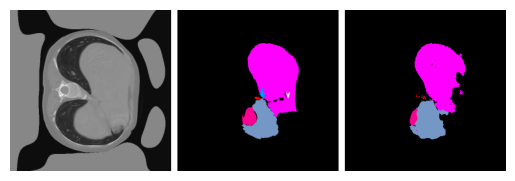

  5%|▍         | 46/944 [00:43<13:03,  1.15it/s]

F1 Score: [0.98784496 0.56886228 0.         0.         0.90524892 0.
 0.85530251 0.5        0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97598185 0.39748954 0.         0.         0.82689932 0.
 0.7471865  0.33333333 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


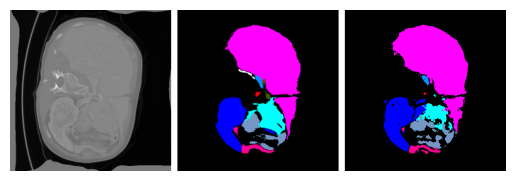

  5%|▍         | 47/944 [00:44<13:06,  1.14it/s]

F1 Score: [0.97918627 0.80053191 0.         0.89587139 0.96966805 0.
 0.64262295 0.56521739 0.78139535 0.         0.65293432 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9592213  0.66740576 0.         0.81138319 0.94112198 0.
 0.47342995 0.39393939 0.64122137 0.         0.4847086  0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


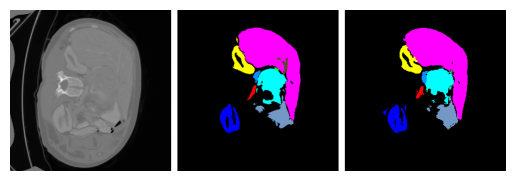

  5%|▌         | 48/944 [00:45<12:58,  1.15it/s]

F1 Score: [0.9863476  0.         0.89346591 0.87676056 0.96338556 0.
 0.82182986 0.74418605 0.71428571 0.18181818 0.84314393 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97306295 0.         0.80744544 0.78056426 0.92935765 0.
 0.69754768 0.59259259 0.55555556 0.1        0.72882353 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


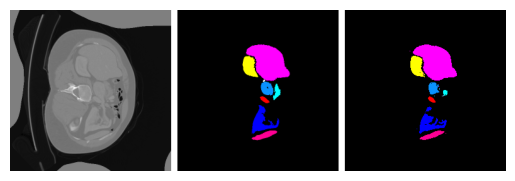

  5%|▌         | 49/944 [00:45<13:02,  1.14it/s]

F1 Score: [0.99546254 0.96761905 0.95100865 0.84233261 0.98203348 0.
 0.         0.91390728 0.83905967 0.         0.53061224 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99096606 0.93726937 0.90659341 0.72761194 0.96470116 0.
 0.         0.84146341 0.72274143 0.         0.36111111 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


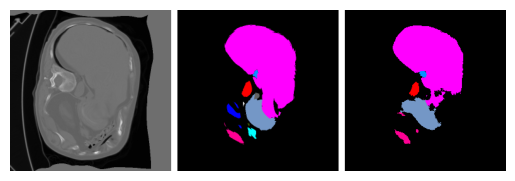

  5%|▌         | 50/944 [00:46<12:59,  1.15it/s]

F1 Score: [0.98083901 0.7938343  0.         0.         0.92925244 0.
 0.80039075 0.94285714 0.66666667 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9623985  0.65814696 0.         0.         0.86785389 0.
 0.66720955 0.89189189 0.5        0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


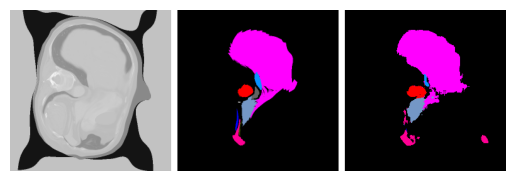

  5%|▌         | 51/944 [00:47<12:50,  1.16it/s]

F1 Score: [0.98642486 0.54076087 0.         0.03225806 0.94115145 0.
 0.83526682 0.71016311 0.67193676 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97321336 0.37057728 0.         0.01639344 0.88884425 0.
 0.71713147 0.55058366 0.50595238 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


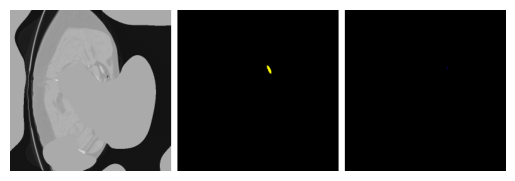

  6%|▌         | 52/944 [00:48<12:45,  1.16it/s]

F1 Score: [0.9996871 0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.        0.
 0.        0.        0.        0.        0.        0.       ]
Jaccard Score: [0.99937439 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


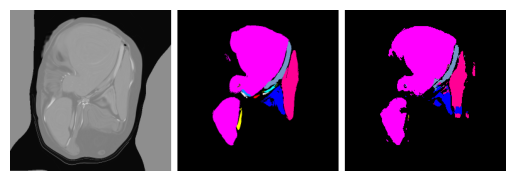

  6%|▌         | 53/944 [00:49<12:38,  1.17it/s]

F1 Score: [0.98464755 0.85267198 0.08163265 0.70114068 0.9506035  0.
 0.82995595 0.         0.         0.0625     0.06779661 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96975937 0.74318065 0.04255319 0.53981265 0.90585732 0.
 0.70933735 0.         0.         0.03225806 0.03508772 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


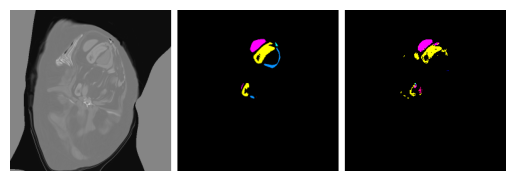

  6%|▌         | 54/944 [00:50<12:38,  1.17it/s]

F1 Score: [0.99694431 0.         0.74885845 0.         0.88888889 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99390724 0.         0.59854015 0.         0.8        0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


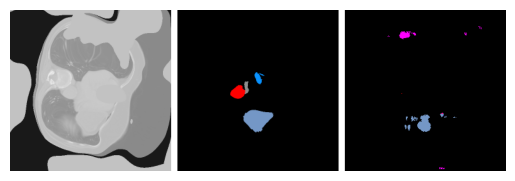

  6%|▌         | 55/944 [00:51<12:37,  1.17it/s]

F1 Score: [0.98938739 0.         0.         0.         0.         0.
 0.562618   0.0060241  0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97899766 0.         0.         0.         0.         0.
 0.39141856 0.00302115 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


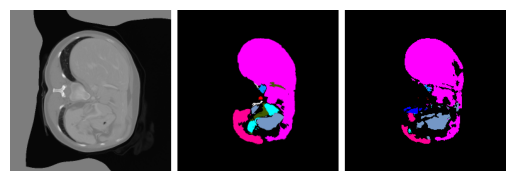

  6%|▌         | 56/944 [00:51<12:36,  1.17it/s]

F1 Score: [0.97817594 0.6225426  0.         0.         0.90609602 0.
 0.69456067 0.23076923 0.49275362 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95728412 0.45195052 0.         0.         0.82831403 0.
 0.53205128 0.13043478 0.32692308 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


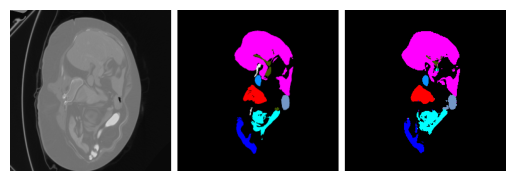

  6%|▌         | 57/944 [00:52<12:27,  1.19it/s]

F1 Score: [0.98912747 0.         0.         0.88028169 0.93123408 0.
 0.81294964 0.91924528 0.94208494 0.42335766 0.75967175 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97848881 0.         0.         0.78616352 0.87131716 0.
 0.68484848 0.85055866 0.89051095 0.26851852 0.61247637 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


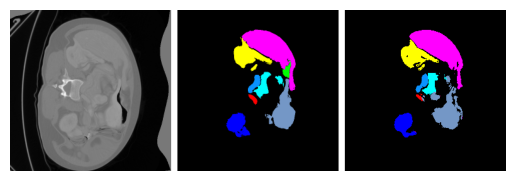

  6%|▌         | 58/944 [00:53<12:18,  1.20it/s]

F1 Score: [0.98596603 0.         0.91871921 0.90764526 0.96564885 0.
 0.76304985 0.67096774 0.91047619 0.         0.76453765 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97232052 0.         0.84965831 0.83090705 0.93357934 0.
 0.61688004 0.50485437 0.83566434 0.         0.61882716 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


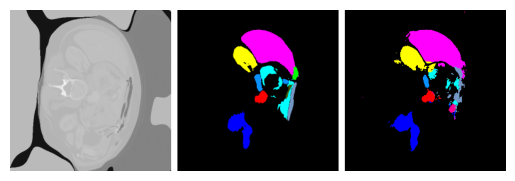

  6%|▋         | 59/944 [00:54<12:14,  1.21it/s]

F1 Score: [0.98527918 0.         0.83138402 0.87885767 0.93600617 0.
 0.25753425 0.87912088 0.67519182 0.03636364 0.40813008 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97098548 0.         0.71142619 0.78389482 0.87971014 0.
 0.14779874 0.78431373 0.50965251 0.01851852 0.25638407 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


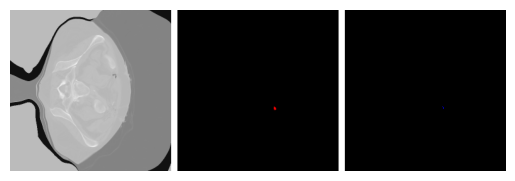

  6%|▋         | 60/944 [00:55<12:13,  1.21it/s]

F1 Score: [0.99990081 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99980164 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


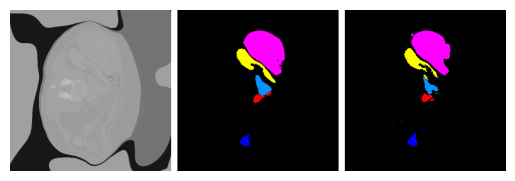

  6%|▋         | 61/944 [00:56<12:13,  1.20it/s]

F1 Score: [0.99407097 0.         0.84238766 0.84020619 0.95426719 0.
 0.         0.73291925 0.79022989 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98821183 0.         0.72769409 0.72444444 0.91253444 0.
 0.         0.57843137 0.65320665 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


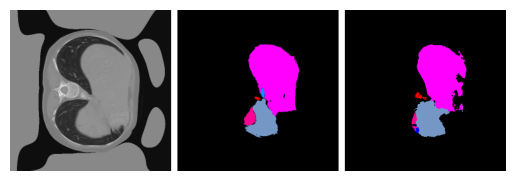

  7%|▋         | 62/944 [00:56<12:18,  1.19it/s]

F1 Score: [0.99007848 0.41137856 0.         0.         0.92523765 0.
 0.8122449  0.28571429 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98035191 0.25895317 0.         0.         0.86087649 0.
 0.6838488  0.16666667 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


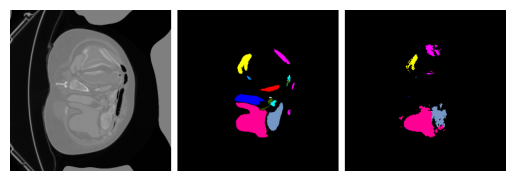

  7%|▋         | 63/944 [00:57<12:15,  1.20it/s]

F1 Score: [0.98366978 0.8580938  0.6989899  0.01727862 0.         0.
 0.59245961 0.         0.23529412 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96786434 0.75145734 0.53726708 0.0087146  0.         0.
 0.42091837 0.         0.13333333 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


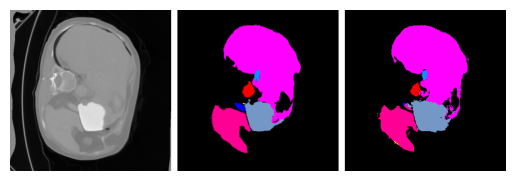

  7%|▋         | 64/944 [00:58<12:22,  1.18it/s]

F1 Score: [0.98585739 0.95517307 0.         0.2173913  0.95086185 0.
 0.84981862 0.85018727 0.86829268 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97210923 0.91419261 0.         0.12195122 0.90632663 0.
 0.73885618 0.73941368 0.76724138 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


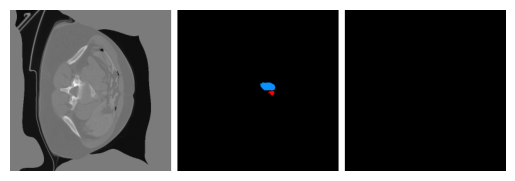

  7%|▋         | 65/944 [00:59<12:15,  1.20it/s]

F1 Score: [0.99807369 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99615479 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


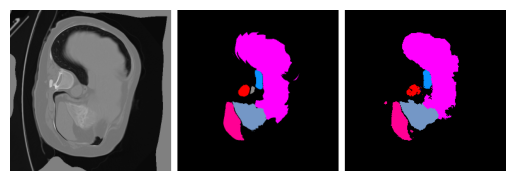

  7%|▋         | 66/944 [01:00<12:08,  1.21it/s]

F1 Score: [0.9889172  0.95424837 0.         0.         0.92817185 0.
 0.89813939 0.79296875 0.8608838  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97807736 0.9125     0.         0.         0.86597077 0.
 0.81511162 0.65695793 0.75574713 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


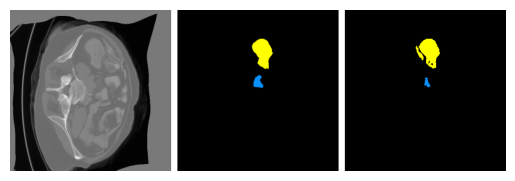

  7%|▋         | 67/944 [01:01<12:18,  1.19it/s]

F1 Score: [0.99776387 0.         0.91516966 0.         0.         0.
 0.         0.         0.56934307 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99553772 0.         0.84360626 0.         0.         0.
 0.         0.         0.39795918 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


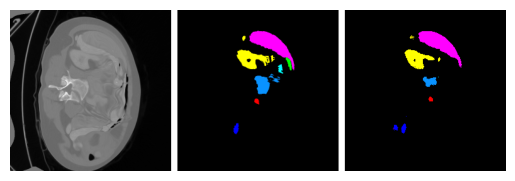

  7%|▋         | 68/944 [01:01<12:13,  1.19it/s]

F1 Score: [0.99253731 0.         0.88217523 0.72       0.9529623  0.
 0.         0.         0.57105263 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98518519 0.         0.78918919 0.5625     0.91015089 0.
 0.         0.         0.39963168 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


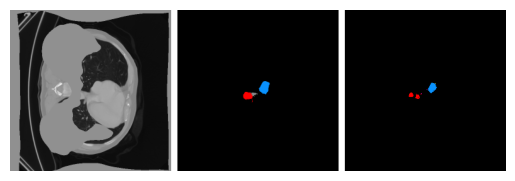

  7%|▋         | 69/944 [01:02<12:10,  1.20it/s]

F1 Score: [0.99862067 0.         0.         0.         0.         0.
 0.         0.53140097 0.76923077 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99724514 0.         0.         0.         0.         0.
 0.         0.36184211 0.625      0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


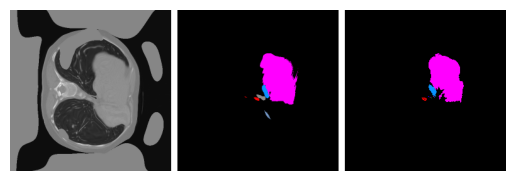

  7%|▋         | 70/944 [01:03<12:08,  1.20it/s]

F1 Score: [0.99592132 0.         0.         0.         0.92771862 0.
 0.         0.8        0.75303644 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99187577 0.         0.         0.         0.86518206 0.
 0.         0.66666667 0.6038961  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


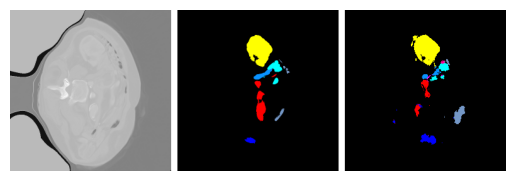

  8%|▊         | 71/944 [01:04<12:12,  1.19it/s]

F1 Score: [0.98557261 0.         0.92122126 0.06091371 0.         0.
 0.         0.33333333 0.64556962 0.         0.57475728 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9715556  0.         0.85394829 0.03141361 0.         0.
 0.         0.2        0.47663551 0.         0.40326975 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


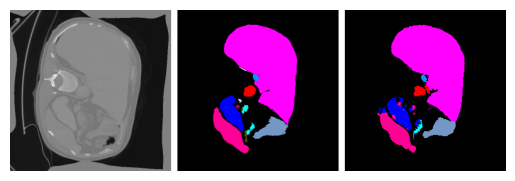

  8%|▊         | 72/944 [01:05<12:50,  1.13it/s]

F1 Score: [0.98901551 0.90403877 0.         0.82647585 0.97897694 0.
 0.91714435 0.69039146 0.8        0.26666667 0.46564885 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97826971 0.82488208 0.         0.70426829 0.95881962 0.
 0.84696824 0.52717391 0.66666667 0.15384615 0.30348259 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


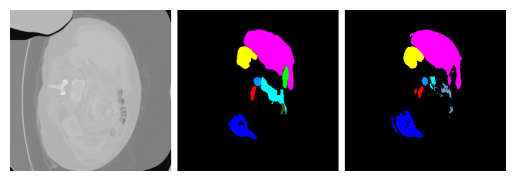

  8%|▊         | 73/944 [01:06<12:48,  1.13it/s]

F1 Score: [0.98541654 0.         0.94       0.82956879 0.95374056 0.
 0.         0.74493927 0.85245902 0.         0.18741977 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97125233 0.         0.88679245 0.70877193 0.91157177 0.
 0.         0.59354839 0.74285714 0.         0.10339943 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


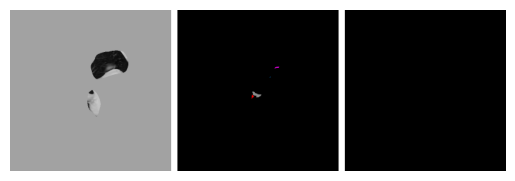

  8%|▊         | 74/944 [01:07<12:32,  1.16it/s]

F1 Score: [0.99990081 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99980164 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


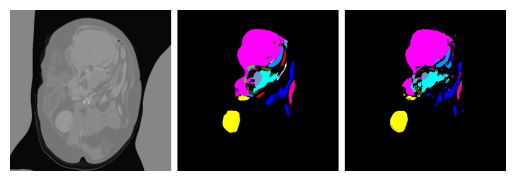

  8%|▊         | 75/944 [01:08<12:48,  1.13it/s]

F1 Score: [0.98977384 0.73780488 0.95289207 0.72434266 0.92788204 0.
 0.46666667 0.         0.7054409  0.375      0.67771334 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9797547  0.58454106 0.91002278 0.56781915 0.86546637 0.
 0.30434783 0.         0.54492754 0.23076923 0.51253133 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


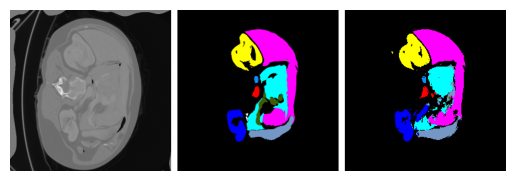

  8%|▊         | 76/944 [01:08<12:34,  1.15it/s]

F1 Score: [0.98162897 0.         0.90547588 0.77148438 0.9334881  0.
 0.78272853 0.66447368 0.8034188  0.098434   0.71892841 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96392075 0.         0.82727814 0.62798092 0.87527209 0.
 0.64301887 0.49753695 0.67142857 0.05176471 0.56119301 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


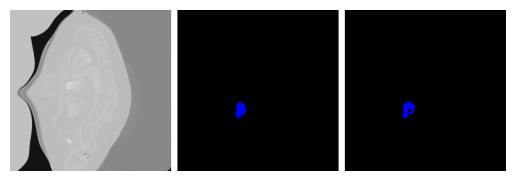

  8%|▊         | 77/944 [01:09<12:27,  1.16it/s]

F1 Score: [0.99901132 0.         0.         0.78319328 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99802459 0.         0.         0.64364641 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


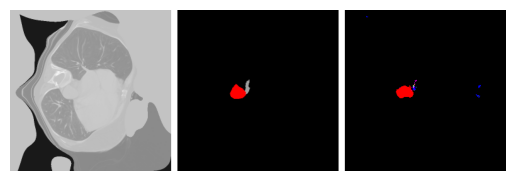

  8%|▊         | 78/944 [01:10<12:19,  1.17it/s]

F1 Score: [0.99866364 0.         0.         0.         0.         0.
 0.         0.87295597 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99733084 0.         0.         0.         0.         0.
 0.         0.77455357 0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


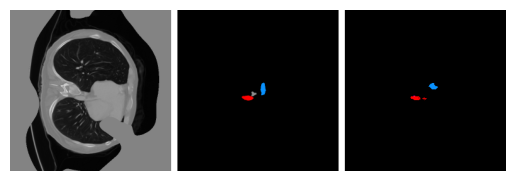

  8%|▊         | 79/944 [01:11<12:17,  1.17it/s]

F1 Score: [0.99879105 0.         0.         0.         0.         0.
 0.         0.83516484 0.33673469 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99758502 0.         0.         0.         0.         0.
 0.         0.71698113 0.20245399 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


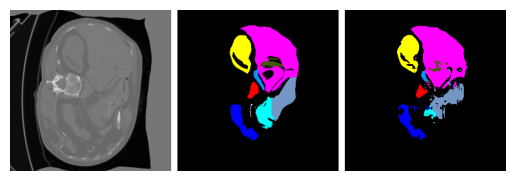

  8%|▊         | 80/944 [01:12<12:14,  1.18it/s]

F1 Score: [0.97998488 0.         0.92271663 0.87209302 0.89153108 0.
 0.6502501  0.78151261 0.71111111 0.2418136  0.37788945 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96075526 0.         0.85652174 0.77319588 0.80429055 0.
 0.48175599 0.64137931 0.55172414 0.13753582 0.23296159 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


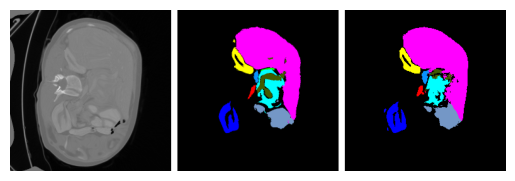

  9%|▊         | 81/944 [01:13<12:22,  1.16it/s]

F1 Score: [0.98390041 0.         0.9266481  0.8900463  0.95515011 0.
 0.84268629 0.75490196 0.63157895 0.29433962 0.60410557 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.968311   0.         0.8633218  0.80187696 0.91415055 0.
 0.7281399  0.60629921 0.46153846 0.17256637 0.43277311 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


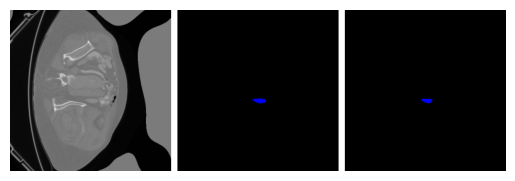

  9%|▊         | 82/944 [01:13<12:24,  1.16it/s]

F1 Score: [0.99988539 0.         0.         0.92307692 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9997708  0.         0.         0.85714286 0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


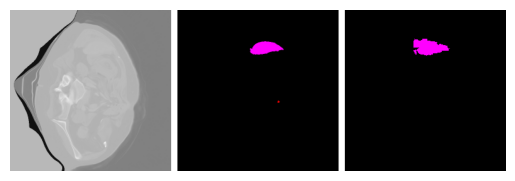

  9%|▉         | 83/944 [01:14<12:16,  1.17it/s]

F1 Score: [0.99717892 0.         0.         0.         0.78669043 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99437371 0.         0.         0.         0.64838394 0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


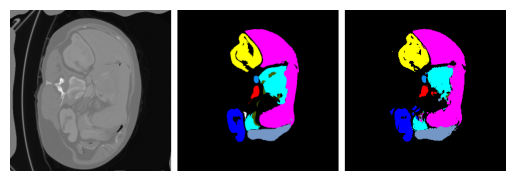

  9%|▉         | 84/944 [01:15<12:09,  1.18it/s]

F1 Score: [0.98453494 0.         0.90937306 0.86088221 0.93179706 0.
 0.90555015 0.77134986 0.80536913 0.21487603 0.77287946 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96954094 0.         0.83380763 0.75574468 0.87230341 0.
 0.82740214 0.62780269 0.6741573  0.12037037 0.62983174 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


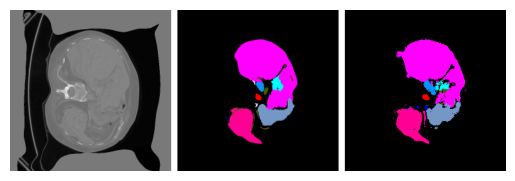

  9%|▉         | 85/944 [01:16<12:04,  1.19it/s]

F1 Score: [0.9885258  0.91322561 0.         0.         0.93572957 0.
 0.82587065 0.81761006 0.6377551  0.         0.55855856 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97731193 0.84030837 0.         0.         0.87922161 0.
 0.70338983 0.69148936 0.46816479 0.         0.3875     0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


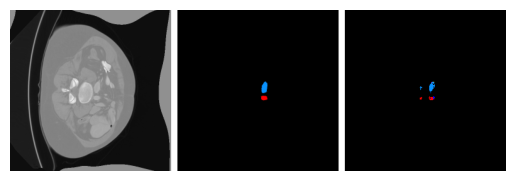

  9%|▉         | 86/944 [01:17<12:04,  1.18it/s]

F1 Score: [0.99938815 0.         0.         0.         0.         0.
 0.         0.64516129 0.75700935 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99877706 0.         0.         0.         0.         0.
 0.         0.47619048 0.60902256 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


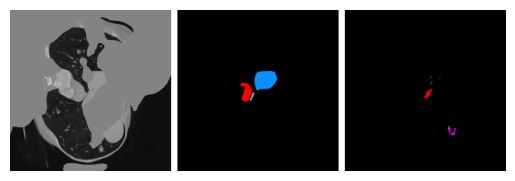

  9%|▉         | 87/944 [01:18<12:01,  1.19it/s]

F1 Score: [0.99014418 0.         0.         0.         0.         0.
 0.         0.         0.0258216  0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98048073 0.         0.         0.         0.         0.
 0.         0.         0.01307967 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


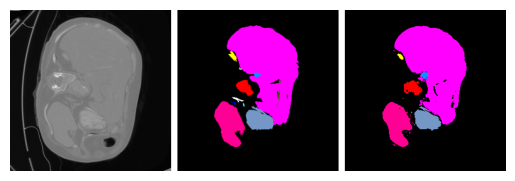

  9%|▉         | 88/944 [01:19<12:03,  1.18it/s]

F1 Score: [0.9899906  0.96760362 0.77697842 0.         0.96897891 0.
 0.93682733 0.84061393 0.69387755 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98017959 0.93724042 0.63529412 0.         0.93982453 0.
 0.88116197 0.72505092 0.53125    0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


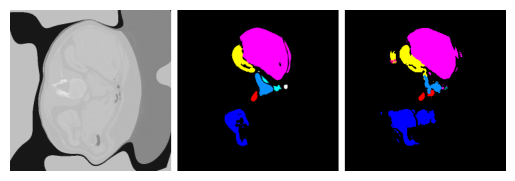

  9%|▉         | 89/944 [01:19<12:19,  1.16it/s]

F1 Score: [0.98284295 0.         0.71182266 0.61989101 0.95688749 0.
 0.         0.651341   0.71801242 0.         0.16981132 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96626469 0.         0.55258126 0.44916091 0.91733871 0.
 0.         0.48295455 0.56007752 0.         0.09278351 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


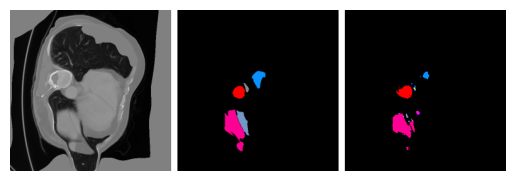

 10%|▉         | 90/944 [01:20<12:20,  1.15it/s]

F1 Score: [0.99336692 0.7988764  0.         0.         0.         0.
 0.15864023 0.86614173 0.42639594 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98682125 0.66510758 0.         0.         0.         0.
 0.08615385 0.76388889 0.27096774 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


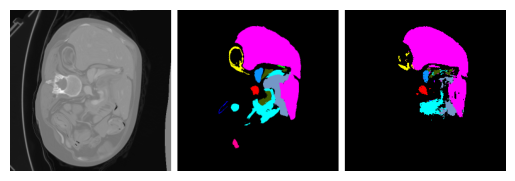

 10%|▉         | 91/944 [01:21<12:17,  1.16it/s]

F1 Score: [0.97928211 0.         0.4519774  0.         0.95777351 0.
 0.48084054 0.81850534 0.79538905 0.37121212 0.55678392 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95940526 0.         0.2919708  0.         0.91896869 0.
 0.31651749 0.69277108 0.66028708 0.22790698 0.38579387 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


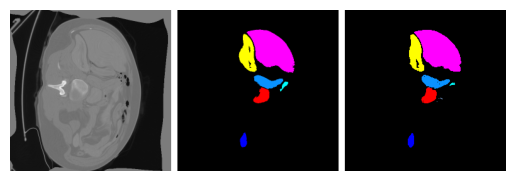

 10%|▉         | 92/944 [01:22<12:13,  1.16it/s]

F1 Score: [0.99617777 0.         0.91301999 0.96531792 0.98251979 0.
 0.         0.91348601 0.93496701 0.         0.54117647 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99238466 0.         0.83996024 0.93296089 0.96564019 0.
 0.         0.84074941 0.87787611 0.         0.37096774 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


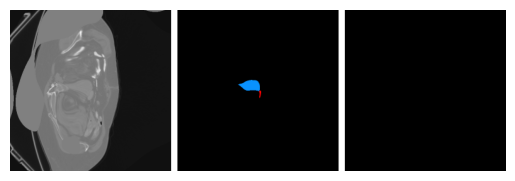

 10%|▉         | 93/944 [01:23<12:23,  1.14it/s]

F1 Score: [0.99683142 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99368286 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


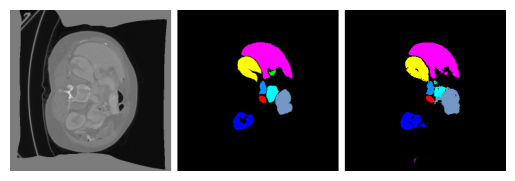

 10%|▉         | 94/944 [01:25<16:49,  1.19s/it]

F1 Score: [0.99235484 0.         0.90715048 0.85849057 0.95893267 0.
 0.84008762 0.91457286 0.86170213 0.         0.73       0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98482569 0.         0.83007812 0.75206612 0.92110533 0.
 0.72426818 0.84259259 0.75700935 0.         0.57480315 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


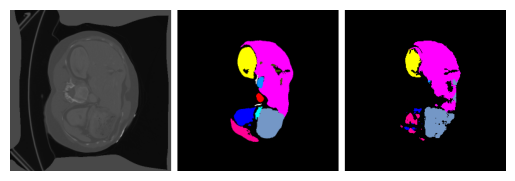

 10%|█         | 95/944 [01:26<15:26,  1.09s/it]

F1 Score: [0.97942258 0.20673077 0.77521127 0.17391304 0.85679423 0.
 0.86652214 0.         0.18918919 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95967495 0.1152815  0.63293468 0.0952381  0.74946633 0.
 0.76448087 0.         0.10447761 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


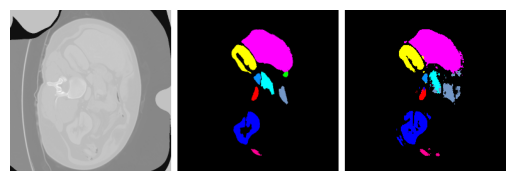

 10%|█         | 96/944 [01:27<14:28,  1.02s/it]

F1 Score: [0.98549839 0.59574468 0.8999465  0.78288431 0.95383223 0.
 0.46356033 0.86131387 0.88679245 0.         0.66853933 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97141136 0.42424242 0.81809339 0.64322917 0.91173926 0.
 0.30171073 0.75641026 0.79661017 0.         0.5021097  0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


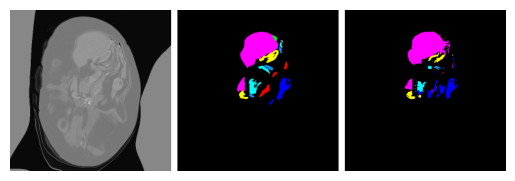

 10%|█         | 97/944 [01:28<14:16,  1.01s/it]

F1 Score: [0.99268946 0.         0.72043011 0.57203842 0.93206951 0.
 0.         0.25806452 0.43939394 0.         0.57333333 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98548503 0.         0.56302521 0.40059791 0.87278107 0.
 0.         0.14814815 0.2815534  0.         0.40186916 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


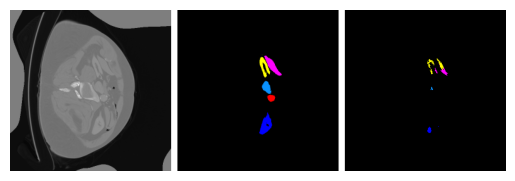

 10%|█         | 98/944 [01:28<13:51,  1.02it/s]

F1 Score: [0.99373328 0.         0.4358209  0.23834197 0.33819242 0.
 0.         0.         0.11956522 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.98754462 0.         0.27862595 0.13529412 0.20350877 0.
 0.         0.         0.06358382 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


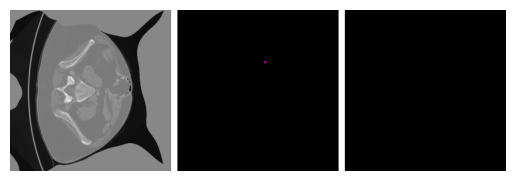

 10%|█         | 99/944 [01:29<13:26,  1.05it/s]

F1 Score: [0.99997711 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99995422 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


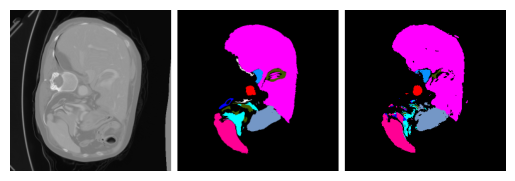

 11%|█         | 100/944 [01:30<13:06,  1.07it/s]

F1 Score: [0.98433889 0.8958544  0.         0.0591716  0.95252352 0.
 0.86500956 0.87830688 0.82460137 0.26287744 0.44813278 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.96916075 0.81135531 0.         0.0304878  0.90935076 0.
 0.76212938 0.78301887 0.70155039 0.15132924 0.28877005 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


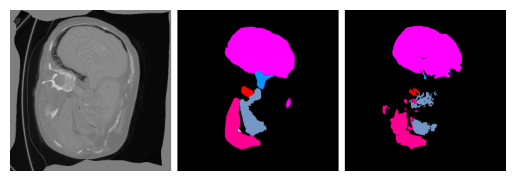

 11%|█         | 101/944 [01:31<12:46,  1.10it/s]

F1 Score: [0.97780261 0.81072637 0.         0.         0.95034483 0.
 0.60562249 0.72839506 0.10784314 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.95656927 0.68169877 0.         0.         0.90538765 0.
 0.4343318  0.57281553 0.05699482 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


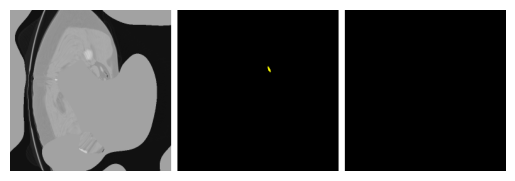

 11%|█         | 102/944 [01:32<12:55,  1.09it/s]

F1 Score: [0.99986265 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99972534 0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


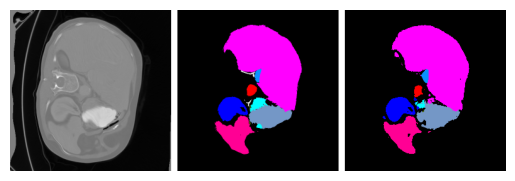

 11%|█         | 103/944 [01:33<12:38,  1.11it/s]

F1 Score: [0.98967376 0.95914091 0.         0.93870697 0.97794803 0.
 0.89886331 0.8195122  0.80769231 0.         0.35864979 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97955861 0.92148968 0.         0.88449367 0.95684765 0.
 0.81630492 0.69421488 0.67741935 0.         0.218509   0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


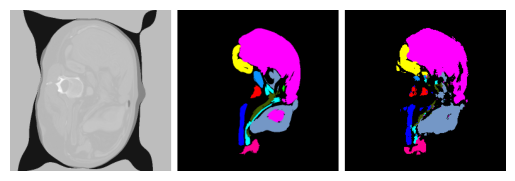

 11%|█         | 104/944 [01:34<13:10,  1.06it/s]

F1 Score: [0.97644959 0.73958333 0.80157171 0.80361991 0.91376602 0.
 0.76128744 0.53191489 0.13249211 0.27891156 0.21454545 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.9539829  0.58677686 0.66885246 0.67170953 0.84122393 0.
 0.61457957 0.36231884 0.07094595 0.16205534 0.12016293 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


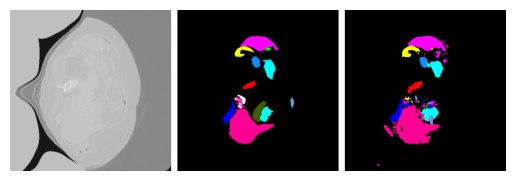

 11%|█         | 105/944 [01:35<13:03,  1.07it/s]

F1 Score: [0.98624451 0.83865616 0.77777778 0.73134328 0.82253818 0.
 0.         0.73087819 0.92260062 0.21553885 0.72230216 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.97286231 0.72214286 0.63636364 0.57647059 0.69856887 0.
 0.         0.57589286 0.85632184 0.12078652 0.56531532 0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


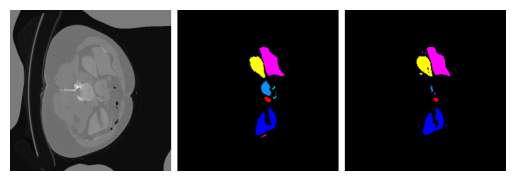

 11%|█         | 106/944 [01:36<12:49,  1.09it/s]

F1 Score: [0.99632315 0.         0.92629482 0.93259972 0.95973154 0.
 0.         0.82222222 0.208      0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]
Jaccard Score: [0.99267324 0.         0.86270872 0.87371134 0.92258065 0.
 0.         0.69811321 0.11607143 0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.        ]


In [ ]:
#test.py

#test.py


import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"

import numpy as np
import cv2
from tqdm import tqdm
import tensorflow as tf
from sklearn.metrics import f1_score, jaccard_score
import matplotlib.pyplot as plt

""" Global parameters """
global IMG_H
global IMG_W
global NUM_CLASSES
global CLASSES
global COLORMAP

def grayscale_to_rgb(mask, classes, colormap):
    h, w, _ = mask.shape
    mask = mask.astype(np.int32)
    output = []

    for i, pixel in enumerate(mask.flatten()):
        output.append(colormap[pixel])

    output = np.reshape(output, (h, w, 3))
    return output

def visualize_results(image, mask, pred):
    h, w, _ = image.shape
    line = np.ones((h, 10, 3)) * 255

    pred = np.expand_dims(pred, axis=-1)
    pred = grayscale_to_rgb(pred, CLASSES, COLORMAP)

    # Create masks for blending
    mask_blend = np.zeros_like(image)
    pred_blend = np.zeros_like(image)

    # Set mask_blend where mask is > 0
    mask_blend = np.where(mask > 0, mask, mask_blend)

    # Set pred_blend where pred is > 0
    pred_blend = np.where(pred > 0, pred, pred_blend)

    # Blend masks with the original image
    original_overlap = (image * (1 - mask_blend) + mask_blend).astype(np.uint8)
    pred_overlap = (image * (1 - pred_blend) + pred_blend).astype(np.uint8)
    
    #cat_images = np.concatenate([image, line, mask, line, pred, line, original_overlap, line, pred_overlap], axis=1)
    cat_images = np.concatenate([image, line, mask, line, pred], axis=1)

    # Display the concatenated images using Matplotlib
    plt.imshow(cat_images.astype(np.uint8))
    plt.axis('off')
    plt.show()

if __name__ == "__main__":
    """ Seeding """
    np.random.seed(42) 
    tf.random.set_seed(42)

    """ Directory for storing files """
    create_dir("results")

    """ Hyperparameters """
    IMG_H = 256
    IMG_W = 256
    NUM_CLASSES = 20
    dataset_path = "/kaggle/input/ultimate-multi-organ-dataset4720/Ultimate_dataset"
    # model_path = os.path.join("files", "model.h5")
    model_path = "/kaggle/working/files/Ultimate_unter_model.h5"

    """ Colormap """
    CLASSES, COLORMAP = get_colormap(dataset_path)

    """ Model """
    model = tf.keras.models.load_model(model_path)

    """ Load the dataset """
    (train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_dataset(dataset_path)
    print(f"Train: {len(train_x)}/{len(train_y)} - Valid: {len(valid_x)}/{len(valid_y)} - Test: {len(test_x)}/{len(test_y)}")
    print("")

    """ Evaluation and Prediction """
    for x, y in tqdm(zip(test_x, test_y), total=len(test_x)):
        """ Extract the name """
        name = x.split("/")[-1].split(".")[0]

        """ Reading the image """
        image = cv2.imread(x, cv2.IMREAD_COLOR)
        image = cv2.resize(image, (IMG_W, IMG_H))
        image_x = image
        # image = image/255.0
        image = np.expand_dims(image, axis=0)

        """ Reading the mask """
        mask = cv2.imread(y, cv2.IMREAD_COLOR)
        mask = cv2.resize(mask, (IMG_W, IMG_H))
        mask_x = mask
        onehot_mask = []
        for color in COLORMAP:
            cmap = np.all(np.equal(mask, color), axis=-1)
            onehot_mask.append(cmap)
        onehot_mask = np.stack(onehot_mask, axis=-1)
        onehot_mask = np.argmax(onehot_mask, axis=-1)
        onehot_mask = onehot_mask.astype(np.int32)

        """ Prediction """
        pred = model.predict(image, verbose=0)[0]
        pred = np.argmax(pred, axis=-1)
        pred = pred.astype(np.float32)

        """ Visualize the results """
        visualize_results(image_x, mask_x, pred)

        """ Flatten the array """
        onehot_mask = onehot_mask.flatten()
        pred = pred.flatten()

        labels = [i for i in range(NUM_CLASSES)]

        """ Calculating the metrics values """
        f1_value = f1_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)
        jac_value = jaccard_score(onehot_mask, pred, labels=labels, average=None, zero_division=0)

        print("F1 Score:", f1_value)
        print("Jaccard Score:", jac_value)